# Lab 9: Diagnostics and model evaluation

### Learning Goals

- Understand the assumptions and relative importance of the main 6 assumptions of regression analysis (ROS p. 153-155)
- Understanding inferential and predictive uncertainty
- Evaluating validity through residual vs. fitted plots
- Evaluating the appropriateness of a model through posterior predictive checks
- Overfitting and use of AIC

### Literature

ROS Ch. 11 (skip 11.5, and you can skim 11.8 on cross-validation, though we will not cover this in the lab). 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as spt

import statsmodels as sms
import statsmodels.formula.api as smf
import seaborn as sns




In [2]:
from cycler import cycler

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams["axes.labelsize"]= 12
plt.rcParams["figure.facecolor"] = "#f2f2f2"
#plt.rcParams['figure.savefig.dpi'] = 100
plt.rcParams['savefig.edgecolor'] = "#f2f2f2"
plt.rcParams['savefig.facecolor'] ="#f2f2f2"
plt.rcParams["figure.figsize"] = [16,10]
plt.rcParams['savefig.bbox'] = "tight"
plt.rcParams['font.size'] = 14
greens = ['#66c2a4','#41ae76','#238b45','#006d2c','#00441b']
multi =['#66c2a4','#1f78b4','#a6cee3','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f']
plt.rcParams["axes.prop_cycle"] = cycler(color=multi)




We'll start with our data set from lab 8: solar panel systems in california: 

In [3]:
pv = pd.read_csv("https://jmaurit.github.io/anv_statistikk/data/pv_csi_new.csv", index_col=0)

Some light cleaning: formatting the date, sorting, creating a centered time variable, creating a quadratic time variable

In [4]:
pv["date"] = pd.to_datetime(pv.date, format="%Y-%m-%d")
pv = pv.sort_values("date")
pv["time_days_m"] = pv.time_days - np.mean(pv.time_days)
pv["time_days_m_sq"] = pv.time_days_m**2

We recall that we estimated a quadratic time trend with regression then plotted it over the data: 

In [5]:
mod1 = smf.ols("cost_per_kw~time_days_m + time_days_m_sq", data=pv).fit()
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            cost_per_kw   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                 2.688e+04
Date:                Mon, 14 Nov 2022   Prob (F-statistic):               0.00
Time:                        14:57:13   Log-Likelihood:            -9.4162e+05
No. Observations:              106551   AIC:                         1.883e+06
Df Residuals:                  106548   BIC:                         1.883e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       6290.8428      6.985    900.577      0.000    6277.152    6304.534
time_days_m       -1.9218      0.009   -215.208      0.000      -1.939      -1.904
time_days_m_sq    -0.0003   1.14e-05    -24.333      0.000      -0.000      -0.000
==============================================================================
Omnibus:                   165044.969   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        591611598.739
Skew:                           9.087   Prob(JB):                         0.00
Kurtosis:                     367.591   Cond. No.                     8.99e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.99e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [6]:
import datetime

T = 2922 # number of days

base = datetime.date(2007, 1, 1)
date_list = [base + datetime.timedelta(days=x) for x in range(T)]
fake_dates = pd.to_datetime(pd.Series([date.strftime("%Y-%m-%d") for date in date_list]))

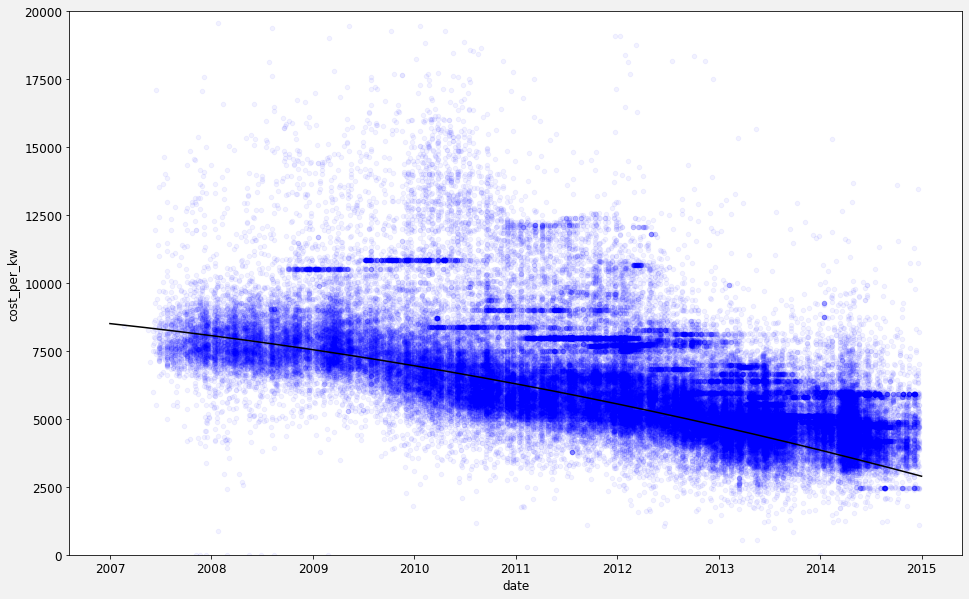

In [7]:
x_line = np.linspace(0 , T, T)
x_line_m = x_line - np.mean(x_line)
y_line = mod1.params[0] + mod1.params[1]*x_line_m + mod1.params[2]*x_line_m**2

fig, ax = plt.subplots()
pv.plot.scatter("date", "cost_per_kw", alpha=.05, color="blue", ax=ax)
ax.set_ylim(0,20000)
ax.plot(fake_dates, y_line, color="black")

But this trend line, is subject to uncertainty - here what we refer to "inferential" uncertainty. That is the uncertainty of the estimate based on the sample given. For a single parameter, we might be able to rely on the standard error in the regression output to give us a good idea of the uncertainty of that estimated parameter, but in cases like above which are functions of several estimators, we can use simulation to generate and draw our uncertainty. 

In ROS, they use a pre-programmed routine for getting out simulations of regression models. We will have to program this ourselves, so this will get a bit technical. 

First let's extract the values we need from the model object: 

In [8]:
df = mod1.df_resid #n-k degrees of freedom
sigma_hat = np.sqrt(mod1.mse_resid) #estimate of sigma, sigma_hat
bs_vcov = mod1.cov_params(scale=1) #unscaled variance-covariance matrix
bs = mod1.params #vector of our parameters
bs_vcov

,Intercept,time_days_m,time_days_m_sq
Intercept,1.757302e-05,-7.169207e-09,-1.957946e-11
time_days_m,-7.169207e-09,2.871991e-11,1.714360e-14
time_days_m_sq,-1.957946e-11,1.714360e-14,4.682003e-17


### A bit about the covariance-variance matrix and where coefficient standard errors come from (a bit technical)

The above is the (unscaled) covariance-variance matrix. We don't want to get too bogged down in the technicalities, but at a basic level, this matrix gives a summary of the variances and covariances among our predictor variables. If you have taken matrix algebra, this covariance matrix is calculated by $(X^TX)^{-1}$.  

We get our "scaled" var-covariance matrix by multiplying by our estimate of the squared standard deviation. 

$$\hat{\sigma}^2(X^tX)^{-1}$$

From this scaled var-covariance matrix we get our coefficient standard errors that are reported in the regression output. We can show the scaled cov-var matrix

In [9]:
vcov_scaled = sigma_hat**2*bs_vcov
vcov_scaled

,Intercept,time_days_m,time_days_m_sq
Intercept,48.795076,-1.990676e-02,-5.436635e-05
time_days_m,-0.019907,7.974667e-05,4.760270e-08
time_days_m_sq,-0.000054,4.760270e-08,1.300053e-10


Notice that this is the same as the the vcov matrix we can extract from the model when we do not specify *scale=1*:

In [10]:
mod1.cov_params()

,Intercept,time_days_m,time_days_m_sq
Intercept,48.795076,-1.990676e-02,-5.436635e-05
time_days_m,-0.019907,7.974667e-05,4.760270e-08
time_days_m_sq,-0.000054,4.760270e-08,1.300053e-10


We could extract the variance component of this matrix by choosing out the item on the diaganol corresponding to *time_days_m*:

In [11]:
vcov_scaled.iloc[1,1]

7.97466722818461e-05

If we wanted to calculate the standard error for just the linear term of the time trend we could take the square root of the variance term: 

In [12]:
np.sqrt(vcov_scaled.iloc[1,1])

0.00893009923135494

You can check the regression output above to see if this corresponds to the reported standard error

### Simulating from a regression output. 

<iframe src="https://ntnu.cloud.panopto.eu/Panopto/Pages/Embed.aspx?id=760fb208-25aa-4bec-b901-af0800c27552&autoplay=false&offerviewer=true&showtitle=true&showbrand=true&captions=false&interactivity=all" height="405" width="720" style="border: 1px solid #464646;" allowfullscreen allow="autoplay"></iframe>

We went through the above discussion of the var-cov matrix from the regression output, because it will be useful in explaining the steps of generating simulations to represent uncertainty from the regression. 

Below we run one simulated "draw" from the regression output. Here we wish to represent uncertainty from two sources. 

$\sigma$ represents the random component in the regression, and we estimate that from the standard deviation of the residuals, $\hat{\sigma}$. But the estimate of of $\hat{\sigma}$ is also uncertain, so we want to take into account that uncertainty in our simulation. We recall from lab 6 that

$$\frac{s^2*(n-k)}{\sigma^2}$$ 

Will have a chi-squared distribution (where s is the sample standard deviation, n-k are the degrees of freedom, and $\sigma$ is the "true" standard deviation).  In our case, we have written the sample standard deviation as $\hat{\sigma}$. Thus we can write: 

$$\frac{\hat{\sigma}^2*(n-k)}{\sigma^2} \sim \chi^2(n-k)$$ 

Where we could also write

$$\sigma^2 \sim \frac{\hat{\sigma}^2*(n-k)}{\chi^2(n-k)}$$

and 

$$\sigma \sim \hat{\sigma} \sqrt{\frac{n-k}{\chi^2(n-k)}}$$



Thus, we can simulate a random draw for $\sigma$ with the command: 

In [13]:
sigma_sim = sigma_hat*np.sqrt((df/np.random.chisquare(df,1)))



We can then create a scaled var-cov matrix: 

In [14]:
V_sim = np.array(bs_vcov) * sigma_sim**2



If the predictive variables in our regression are completly independent (and assuming normality, as we are now), then all the information we would need to simulate uncertainty is the reported standard errors of the individual coefficients (in this case, the non-diagonal entries in the var-cov matrix would be 1). 

But that is obviously not the case in our situation (where one variable is simply the square of another variable), and in general this should not be assumed to be the case. Then the uncertainty of one variable is dependent on the uncertainty of the others (this is what the covariance captures). 

So therefor, when we simulate values of our coefficients, we can't simulate them individually from a single normal distribution, instead we need to simulate them together from a **multivariate normal** distribution, where we include the estimated coefficients (*bs*) as the mean variables and we need to include the entire scaled variance-covariance matrix to describe the spread of the distribution. We simulate a vector of values below: 

In [15]:
bs_sim = np.random.multivariate_normal(bs, V_sim, 1)
bs_sim

array([[ 6.29829069e+03, -1.92722024e+00, -2.87640725e-04]])

Notice in the simulation of our coefficients, *bs_sim* we have included two forms of uncertainty. First, there is the direct uncertainty from the multivariate normal distribution. So basically we could run the command above many times to generate a multivariate distribution of the 3 coefficients. 

But notice that we do not directly include the estimated variance-covariance matrix in our command. Instead we use the simulated variance-covariance matrix. Running a loop, we would then get slightly different versions of the covariance-variance matrix, and in this way we also include uncertainty about the variance parameters as well. 

Below we gather all the commands that extract information from a linear regression model and create simulated values within a function, which takes a statsmodels regression model object as an argument and returns a vector of simulated b coefficients and the simulated $\sigma$ values. 

In [16]:
def regSim(regMod): 
    #extract values from regression model
    nmk = regMod.df_resid #n-k
    sigma_hat = np.sqrt(regMod.mse_resid)
    bs_vcov = regMod.cov_params(scale=1)
    bs = regMod.params
    
    #create simulated values
    sigma_sim = sigma_hat*np.sqrt((nmk/np.random.chisquare(nmk,1)))
    V_sim = np.array(bs_vcov) * sigma_sim**2
    bs_sim = np.random.multivariate_normal(bs, V_sim, 1)
    
    return([bs_sim.flatten(), sigma_sim])


The above has been rather technical, and the details of what we have done are actually outside of the scope of this course. If you want to learn more about the mathematics we used above, you could take courses in mathematical statistics or linear algebra (for example [MET 430](https://www.ntnu.edu/studies/courses/MET430#tab=omEmnet))

We can be happy instead to have a rather general function, above, which we can easily copy and paste when we need to simulate uncertainty in regression coefficients. 

We can then run a simulation, calling the above function:

In [17]:
nsim = 50

bs_sims = []
sigma_sims = []



for s in range(nsim):
    param_sim = regSim(mod1)
    bs_sims.append(param_sim[0])
    sigma_sims.append(param_sim[1])
    

Now that we have simulations of b coefficients saved in *bs_sims*, we can visualise this inferential uncertainty

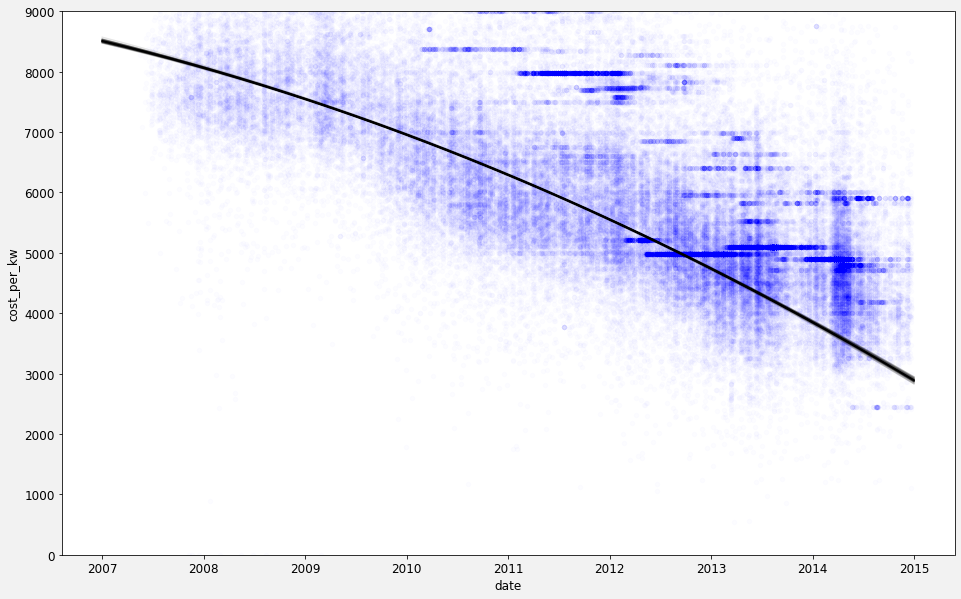

In [18]:
fig, ax = plt.subplots()
pv.plot.scatter("date", "cost_per_kw", alpha=.01, color="blue", ax=ax)
ax.set_ylim(0,12000)
ax.plot(fake_dates, y_line, color="black")
ax.set_ylim(0,9000)


for i in range(nsim):
    y_line_sim = bs_sims[i][0] + bs_sims[i][1]*x_line_m + bs_sims[i][2]*x_line_m**2
    ax.plot(fake_dates, y_line_sim, color="black", alpha=.1)



### Predictive uncertainty

To generate predictive uncertainty, all we actually need to do is to generate an extra error term based on our estimated model standard deviation, $\hat{\sigma}$: 

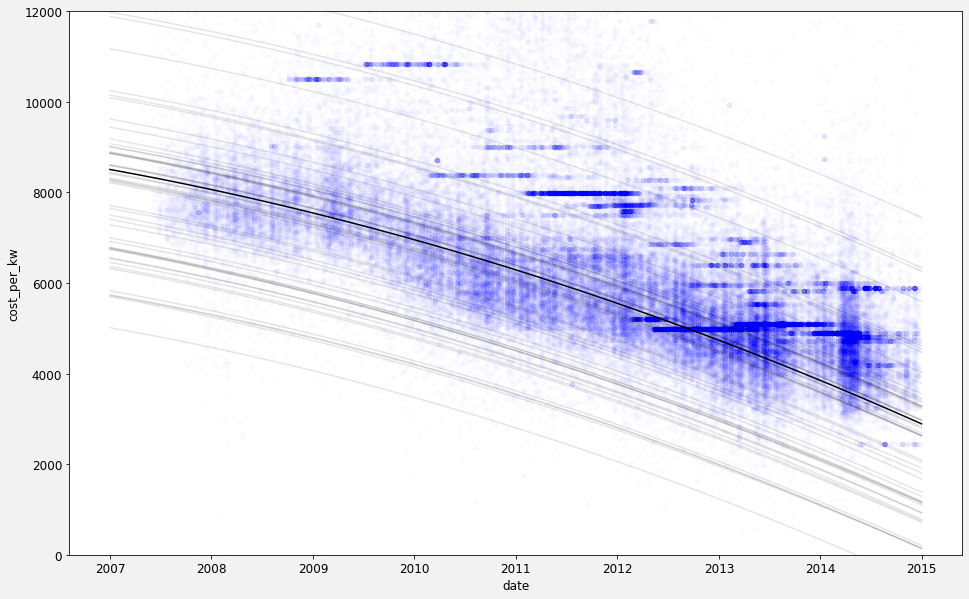

In [19]:
fig, ax = plt.subplots()
pv.plot.scatter("date", "cost_per_kw", alpha=.01, color="blue", ax=ax)
ax.set_ylim(0,12000)
ax.plot(fake_dates, y_line, color="black")


for i in range(nsim):
    y_line_sim = bs_sims[i][0] + bs_sims[i][1]*x_line_m + bs_sims[i][2]*x_line_m**2 + np.random.normal(0,sigma_hat)
    ax.plot(fake_dates, y_line_sim, color="black", alpha=.1)




### Residual vs. fitted Plot

<iframe src="https://ntnu.cloud.panopto.eu/Panopto/Pages/Embed.aspx?id=dc194065-7583-483c-9c14-af0800c2755b&autoplay=false&offerviewer=true&showtitle=true&showbrand=true&captions=false&interactivity=all" height="405" width="720" style="border: 1px solid #464646;" allowfullscreen allow="autoplay"></iframe>

An important tool in evaluating the validity and appropriateness of a regression model are plots of the residuals - that is the differences between the predicted values from the regression model and the actual data. Below we plot the residuals from our model with quadratic trend. 

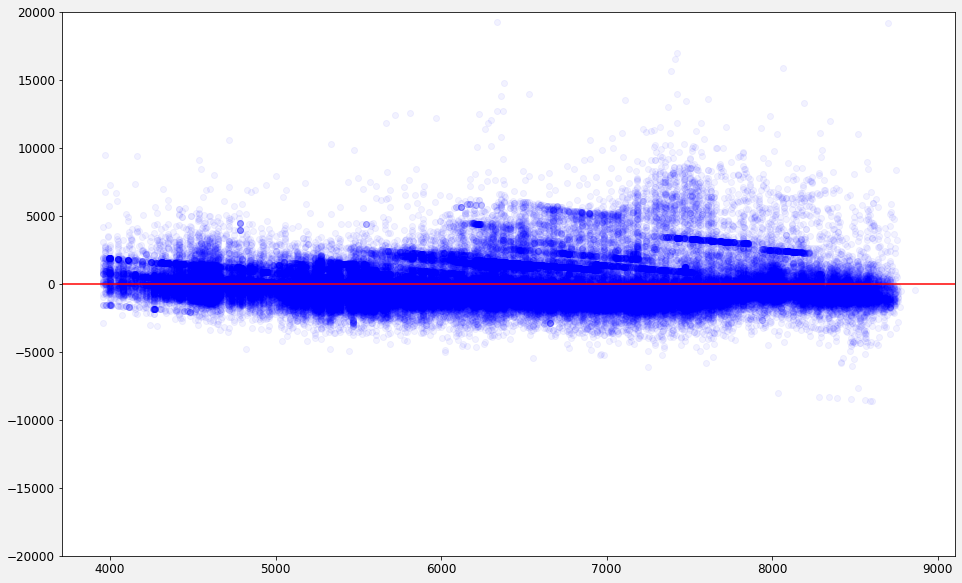

In [20]:
fig, ax = plt.subplots()
ax.scatter(mod1.fittedvalues, mod1.resid, alpha=.05, color="blue")
ax.set_ylim(-20000, 20000)
ax.axhline(0, color="red")



What we want to look for in the residual plots are any clear patterns in the figure. Ideally, if we have done a good job with the modelling, we should see random dots centered around 0. 

The plot above doesn't look too bad, but there are a few things that might worry us in a data analysis. 

- There is some clear structure in the residuals - you can see what appears to be clear streaks in the data. This is probably something we would like to understand, and ideally model explicitly. 

- It also looks like there might be more variance towards the end of the period - more large, positive residuals. This might violate our principle that the error variance is constant (though violations of this error are in practice usually not the most important). 

### Why residuals vs. predicted and *not* residuals vs actual

You may have wondered why we plotted the residuals vs fitted values, rather than residuals vs actual values. Let us do a fake-data simulation to show why. 

In [21]:
T=3000
t = np.arange(0,T)
a = 9000
b1 = -1.9
b2 = -.001
sigma = 1500


y_f = a + b1*t + b2*(t**2) + np.random.normal(0,sigma,T)

fdata = pd.DataFrame({"y_f":y_f, "t":t, "tsq":t**2})



In [22]:
y_f

array([ 9426.75149248, 10653.40000102,  9017.95412196, ...,
       -9441.10329796, -3257.78499573, -8167.01534774])

<AxesSubplot:xlabel='t', ylabel='y_f'>

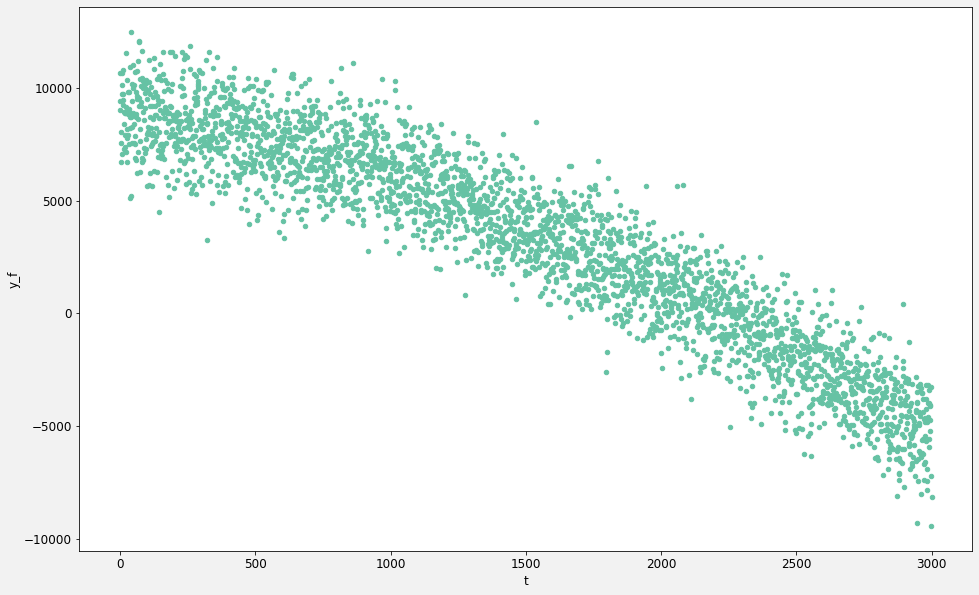

In [23]:
fdata.plot.scatter("t", "y_f")

In [24]:
mod_f1 = smf.ols(formula="y_f~t + tsq", data=fdata).fit()


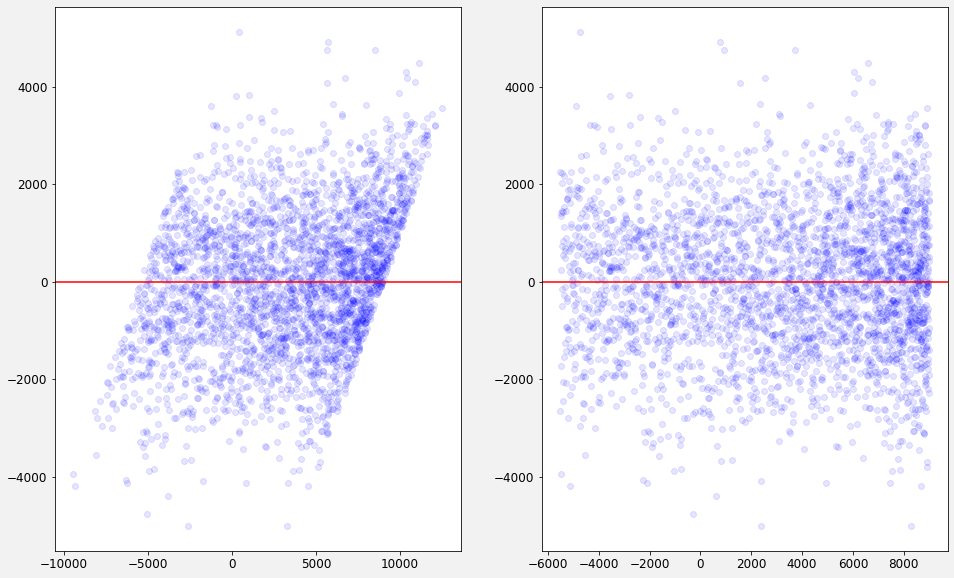

In [25]:
fig, ax = plt.subplots(1,2)
ax[0].scatter(fdata.y_f, mod_f1.resid, alpha=.1, color="blue")
ax[0].axhline(0, color="red")
ax[1].scatter(mod_f1.fittedvalues, mod_f1.resid, alpha=.1, color="blue")
ax[1].axhline(0, color="red")

With our made-up data, we know that the residuals should--by design-- be completly random, yet we see in the first panel a clear trend. The reason is that the error terms - which the residuals estimate - are part of the y-values. This is why we compare residuals and fitted values (which exclude the error term), as in the right panel. (See ROS p. 162-163 for more discussion). 

### Posterior predictive checking

<iframe src="https://ntnu.cloud.panopto.eu/Panopto/Pages/Embed.aspx?id=f40d61fa-14f8-49a2-b4d7-af0800c27551&autoplay=false&offerviewer=true&showtitle=true&showbrand=true&captions=false&interactivity=all" height="405" width="720" style="border: 1px solid #464646;" allowfullscreen allow="autoplay"></iframe>

We can make use of simulation to further check the appropriateness of our model - doing what ROS call **posterior predictive checking**

Below, we will create 20 sets of new fake data, each data set based on simulated parameters (using the regSim() function we created above). 

In [26]:
nsim = 20


x_line = np.linspace(0 , T, T)
x_line_m = x_line - np.mean(x_line)

y_fs = [] #list of fake data


for s in range(nsim):
    param_sim = regSim(mod1) # generate simulated coefficients
    bs_sim = param_sim[0]
    sigma_sim = param_sim[1]
    y_fs.append(bs_sim[0] + bs_sim[1]*x_line_m + mod1.params[2]*x_line_m**2 + np.random.normal(0,sigma_sim,T))




First, let's take a histogram of the actual data: 

(0.0, 20000.0)

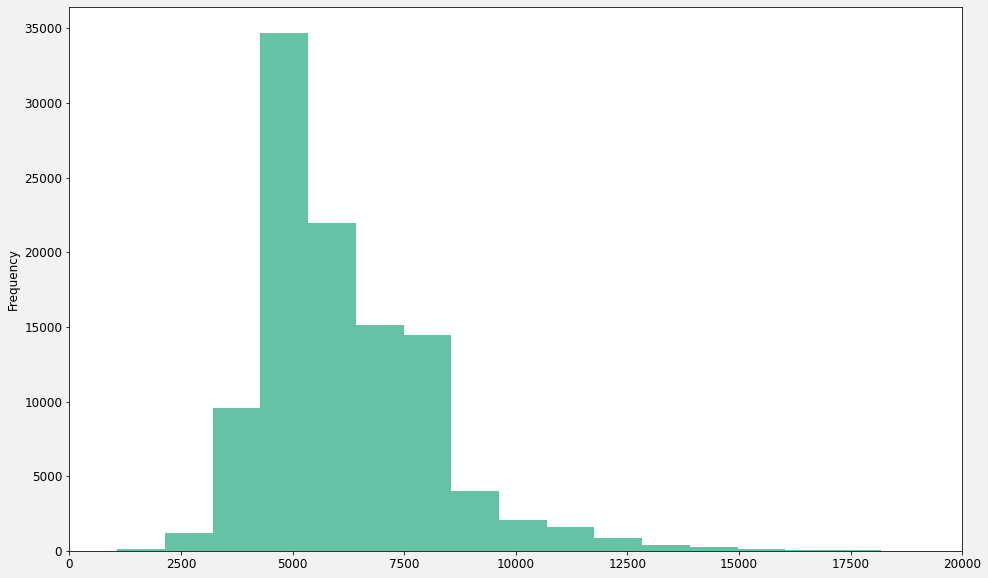

In [27]:
fix, ax = plt.subplots()
pv.cost_per_kw.plot.hist(bins=100, ax=ax)
ax.set_xlim(0,20000)


Now we display histograms of the 20 fake data sets in a faceted chart:

In [28]:
y_fs[19]

array([ 8053.35049341,  6718.62095228, 11285.87937323, ...,
        1456.02914642,  5303.67284794,  2619.609375  ])

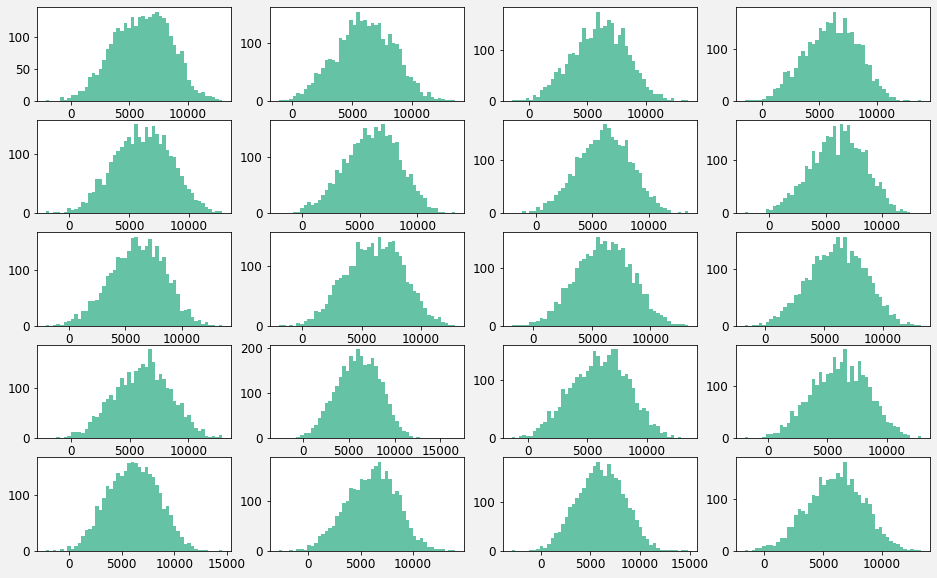

In [29]:
i = 0
fix, ax = plt.subplots(5,4)
for r in range(5):
    for c in range(4):
        ax[r,c].hist(y_fs[i], bins=50)
        i+=1
        
        

In [30]:
yf_df = pd.DataFrame(np.transpose(y_fs))

In [31]:
colnames = ["sim" + str(i) for i in range(20)]
yf_df.columns = colnames


Here using an empirical density function (basically a smoothed, de-scaled histogram) from seaborn, we can plot the actual data and the simulations using our model on the same chart. 

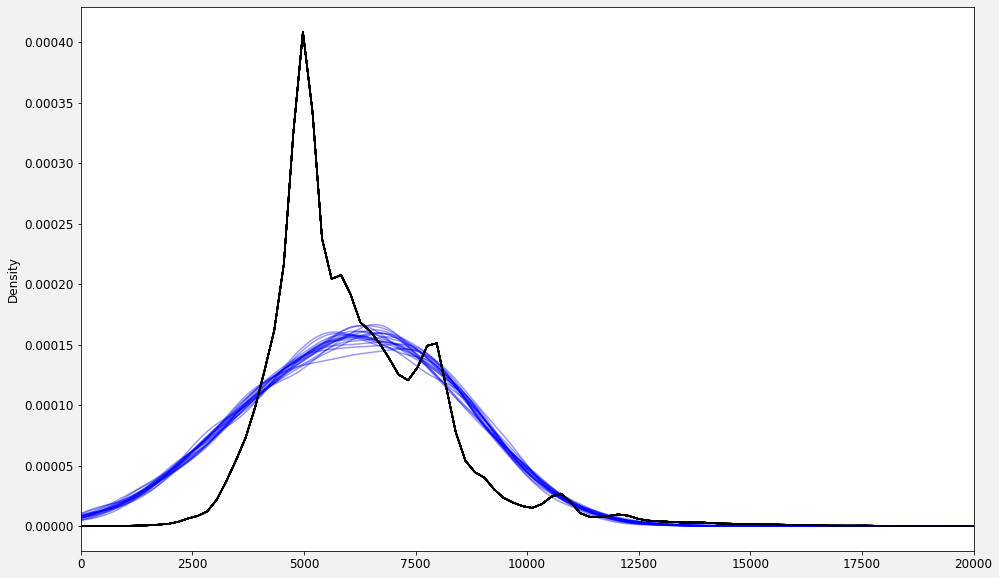

In [35]:
fig, ax=plt.subplots()

for name, values in yf_df.iteritems():
  values.plot.density(ax=ax, alpha=.4, color="blue")
  pv.cost_per_kw.plot.density(ax=ax, color="black")

  #or you could use kdeplot function in seaborn
  #sns.kdeplot(x=values, ax=ax, alpha=.3)
  #sns.kdeplot(x=pv.cost_per_kw, ax=ax, color="black")
  ax.set_xlim(0,20000)

Clearly the actual data, and the simulated data from our estimated model are quite different. This suggests that a quadratic time trend alone is not a good representation of our data. 

### Overfitting and AIC

If you have a large data set with many potential explanatory variables in a model, you risk *overfitting* the data. Intuitively, what this means is that you devise a model with a good or very good fit in terms of traditional measures such as $R^2$, but which would perform relatively poorly out-of-sample, which is generally what we would be interested in--whether we are interested in inference or prediction. 

There are various tools available to try to avoid overfitting, and one of the most common are *information criteria* AIC (Akaiki Information Criteria) or the similar BIC (Bayesian Information Criteria.) At a basic level, these criteria penalize the number variables used in your regression relative to the fit of the model. 

ROS (p.175) provides some more details on the mathematics, but as a practical matter, when comparing models with AIC (or BIC) you are aiming for the lowest possible value for AIC. 

We can look at an example using our PV data. We consider three models, estimated by maximum likelihood (using the smf.glm routine). 

In the first model we include several explanatory variables

In [53]:
AICmod1 = smf.glm("cost_per_kw~time_days + time_days_sq + nameplate + sector + incentive_amount + contractor_year_total + county_year_total + nationality + county", data=pv).fit()
AICmod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            cost_per_kw   No. Observations:               104992
Model:                            GLM   Df Residuals:                   104921
Model Family:                Gaussian   Df Model:                           70
Link Function:               identity   Scale:                      2.5645e+06
Method:                          IRLS   Log-Likelihood:            -9.2364e+05
Date:                Fri, 19 Aug 2022   Deviance:                   2.6907e+11
Time:                        11:43:18   Pearson chi2:                 2.69e+11
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                   8175.3223     60.653    134.788      0.000    8056.444    8294.200
sector[T.Government]        1553.8691     95.277     16.309      0.000    1367.130    1740.608
sector[T.Non-Profit]        -394.0940     93.473     -4.216      0.000    -577.298    -210.890
sector[T.Residential]        141.0004     42.322      3.332      0.001      58.050     223.950
nationality[T.China]          -9.5275     23.205     -0.411      0.681     -55.009      35.954
nationality[T.Germany]       237.5124     25.727      9.232      0.000     187.088     287.937
nationality[T.India]        -416.9158    116.606     -3.575      0.000    -645.459    -188.372
nationality[T.Japan]         743.7618     23.208     32.048      0.000     698.276     789.248
nationality[T.Norway]        299.5515     28.062     10.675      0.000     244.552     354.551
nationality[T.South Korea]  -313.9075     31.349    -10.013      0.000    -375.351    -252.464
nationality[T.Spain]         541.6003     31.456     17.218      0.000     479.948     603.253
nationality[T.Taiwan]         -4.4749     58.220     -0.077      0.939    -118.584     109.634
nationality[T.US]            240.9810     24.312      9.912      0.000     193.330     288.632
county[T.Amador]            -610.8413    141.328     -4.322      0.000    -887.840    -333.843
county[T.Butte]             -796.2775     67.392    -11.816      0.000    -928.363    -664.192
county[T.Calaveras]         -698.5247    100.898     -6.923      0.000    -896.281    -500.769
county[T.Colusa]            -687.6262    203.560     -3.378      0.001   -1086.597    -288.656
county[T.Contra Costa]        31.9526     36.682      0.871      0.384     -39.943     103.848
county[T.El Dorado]         -432.0518     54.580     -7.916      0.000    -539.026    -325.078
county[T.Fresno]            -408.3648     36.137    -11.301      0.000    -479.191    -337.538
county[T.Glenn]             -653.4635    135.800     -4.812      0.000    -919.627    -387.300
county[T.Humboldt]          -157.7739    143.659     -1.098      0.272    -439.341     123.793
county[T.Imperial]         -1574.0199    716.694     -2.196      0.028   -2978.714    -169.326
county[T.Inyo]              -696.7596    258.177     -2.699      0.007   -1202.777    -190.743
county[T.Kern]              -233.0457     37.348     -6.240      0.000    -306.246    -159.845
county[T.Kings]             -464.1639     71.612     -6.482      0.000    -604.522    -323.806
county[T.Lake]              -424.9604    117.638     -3.612      0.000    -655.528    -194.393
county[T.Lassen]           -1298.6269    534.481     -2.430      0.015   -2346.191    -251.063
county[T.Los Angeles]        453.7279     34.884     13.007      0.000     385.357     522.099
county[T.Madera]            -515.8510     7

We notice that contractor_year_total is estimated to be insignificant, so we test a model that does not include this variable: 

In [54]:
AICmod2 = smf.glm("cost_per_kw~time_days + time_days_sq + nameplate + sector + incentive_amount + county_year_total + nationality + county", data=pv).fit()
AICmod2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            cost_per_kw   No. Observations:               104992
Model:                            GLM   Df Residuals:                   104922
Model Family:                Gaussian   Df Model:                           69
Link Function:               identity   Scale:                      2.5645e+06
Method:                          IRLS   Log-Likelihood:            -9.2364e+05
Date:                Fri, 19 Aug 2022   Deviance:                   2.6907e+11
Time:                        11:43:20   Pearson chi2:                 2.69e+11
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                   8168.6765     60.478    135.068      0.000    8050.142    8287.211
sector[T.Government]        1556.9459     95.253     16.345      0.000    1370.253    1743.639
sector[T.Non-Profit]        -393.8143     93.474     -4.213      0.000    -577.019    -210.609
sector[T.Residential]        144.1989     42.264      3.412      0.001      61.362     227.035
nationality[T.China]           1.1283     21.997      0.051      0.959     -41.985      44.241
nationality[T.Germany]       236.6076     25.720      9.199      0.000     186.198     287.017
nationality[T.India]        -418.4223    116.602     -3.588      0.000    -646.958    -189.887
nationality[T.Japan]         746.8675     23.107     32.321      0.000     701.578     792.157
nationality[T.Norway]        302.2982     27.997     10.798      0.000     247.425     357.171
nationality[T.South Korea]  -308.2476     31.103     -9.911      0.000    -369.208    -247.287
nationality[T.Spain]         543.0528     31.440     17.273      0.000     481.432     604.674
nationality[T.Taiwan]          3.0341     57.987      0.052      0.958    -110.618     116.686
nationality[T.US]            243.3217     24.258     10.030      0.000     195.776     290.867
county[T.Amador]            -612.3528    141.325     -4.333      0.000    -889.345    -335.361
county[T.Butte]             -797.4236     67.387    -11.833      0.000    -929.500    -665.347
county[T.Calaveras]         -701.1570    100.882     -6.950      0.000    -898.881    -503.433
county[T.Colusa]            -689.9858    203.555     -3.390      0.001   -1088.946    -291.026
county[T.Contra Costa]        31.1818     36.678      0.850      0.395     -40.707     103.070
county[T.El Dorado]         -431.6335     54.579     -7.908      0.000    -538.607    -324.660
county[T.Fresno]            -407.7568     36.134    -11.284      0.000    -478.579    -336.935
county[T.Glenn]             -655.6697    135.792     -4.828      0.000    -921.817    -389.522
county[T.Humboldt]          -161.0505    143.642     -1.121      0.262    -442.584     120.483
county[T.Imperial]         -1577.7406    716.693     -2.201      0.028   -2982.433    -173.049
county[T.Inyo]              -702.7806    258.144     -2.722      0.006   -1208.734    -196.827
county[T.Kern]              -231.7396     37.337     -6.207      0.000    -304.919    -158.561
county[T.Kings]             -462.7958     71.606     -6.463      0.000    -603.142    -322.450
county[T.Lake]              -426.7657    117.632     -3.628      0.000    -657.321    -196.210
county[T.Lassen]           -1305.1601    534.465     -2.442      0.015   -2352.692    -257.628
county[T.Los Angeles]        453.9785     34.883     13.014      0.000     385.608     522.349
county[T.Madera]            -515.8495     7

We also notice that the county indicator increases the number of variables significantly and that some of the county indicators are insignificant, so we also test a model that does not include the county indicators (nor the contractor_year_total variable

In [57]:
AICmod3 = smf.glm("cost_per_kw~time_days + time_days_sq + nameplate + sector + incentive_amount + county_year_total + nationality", data=pv).fit()
AICmod3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            cost_per_kw   No. Observations:               104992
Model:                            GLM   Df Residuals:                   104974
Model Family:                Gaussian   Df Model:                           17
Link Function:               identity   Scale:                      2.6723e+06
Method:                          IRLS   Log-Likelihood:            -9.2583e+05
Date:                Fri, 19 Aug 2022   Deviance:                   2.8052e+11
Time:                        11:46:19   Pearson chi2:                 2.81e+11
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                   7936.1780     56.336    140.873      0.000    7825.762    8046.594
sector[T.Government]        1494.6229     96.998     15.409      0.000    1304.510    1684.736
sector[T.Non-Profit]        -319.7908     95.256     -3.357      0.001    -506.489    -133.092
sector[T.Residential]        159.6865     42.993      3.714      0.000      75.422     243.951
nationality[T.China]         -44.0798     22.388     -1.969      0.049     -87.959      -0.201
nationality[T.Germany]       170.6008     26.113      6.533      0.000     119.421     221.780
nationality[T.India]        -393.2389    118.945     -3.306      0.001    -626.366    -160.112
nationality[T.Japan]         725.7274     23.515     30.862      0.000     679.638     771.817
nationality[T.Norway]        250.0802     28.359      8.818      0.000     194.498     305.662
nationality[T.South Korea]  -334.5783     31.679    -10.562      0.000    -396.668    -272.489
nationality[T.Spain]         537.0907     32.003     16.783      0.000     474.367     599.815
nationality[T.Taiwan]        -32.4240     59.124     -0.548      0.583    -148.305      83.457
nationality[T.US]            227.8450     24.720      9.217      0.000     179.394     276.296
time_days                     -0.5808      0.038    -15.108      0.000      -0.656      -0.505
time_days_sq                  -0.0003    1.2e-05    -27.276      0.000      -0.000      -0.000
nameplate                     -9.7523      0.616    -15.835      0.000     -10.959      -8.545
incentive_amount               0.0041      0.000     17.709      0.000       0.004       0.005
county_year_total              0.0111      0.001     18.546      0.000       0.010       0.012
==============================================================================================
"""

We can get the AIC directly from the result object: 

In [58]:
print("AIC Mod 1", AICmod1.aic)
print("AIC Mod 2", AICmod2.aic)
print("AIC Mod 3", AICmod3.aic)

AIC Mod 1 1847420.669942441
AIC Mod 2 1847420.7497015435
AIC Mod 3 1851691.3231616323


The actual absolute value of the numbers don't mean anything to us, only the relative size of them. So we see that not including the contractor_year_total variable increases the AIC (leads to relatively worse fit). Thus even though that variable is not estimated to be statistically significant, it still improves the fit of the model. 

This is even more so for the the country indicators, where we see that excluding this indicators also increases the AIC value. 

We can also get the BIC values

In [59]:
print("BIC Mod 1", AICmod1.bic)
print("BIC Mod 2", AICmod2.bic)
print("BIC Mod 3", AICmod3.bic)

BIC Mod 1 269067625809.17706
BIC Mod 2 269072955764.7493
BIC Mod 3 280520979280.5464


/Users/johannesmauritzen/opt/anaconda3/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:1721: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(


In this case, we get the same end results - the first model is shown to provide the best fit. But this is not always the case. BIC tends to be more conservative, in the sense of "preferring" fewer explanatory variables. 

In a situation where AIC and BIC give conflicting indications, often the choice comes down to whether you, from a theoretical perspective, have a good reason for including a certain variable.

### Cross-validation

We won't cover cross-validation in the lab, but it is an important tool for checking the fit of the model and is used extensively, especially in machine-learning applications. 

Within the package [scikit-learn](https://scikit-learn.org/stable/modules/cross_validation.html) there are some robust algorithms for doing cross-validation. 

# Assignment

## 1: Plotting the outcome vs. a continuous predictor

On page 158-159 in ROS fake data is created in r and the authors demonstrate how to plot a outcome variable against a continuous predictor with a treatment indicator ("Plotting the outcome vs. a continuous predictor", figures 11.3-11.5). Redo this (approximately) in python. 

Hint: to generate random draws from [0,1], you can use np.random.randint(0,2,N)

## 2: Posterior Predictive Check

For our model of pv prices, add predictors to our model (for exampe the *china* indicator, and potentially other indicators. 

Run posterior predictive checks using simulation. Display faceted histogram charts and overlayed empirical density charts. 

Instead of plotting histograms/densities of the actual/simulated outcome data (cost_per_kw), plot residuals/simulated residuals (vs fitted) instead. What information does this provide. 


# 3:  External validity

There are several formal methods and tests for testing for external validity--avoiding overfitting, cross-validation, etc. But a more basic test is simply to see how your model behaves outside your (test) dataset.

- Based on the regression model in assignment 2, create a prediction model for the future data. See the statsmodels documentation on [prediction](https://www.statsmodels.org/dev/examples/notebooks/generated/predict.html) on prediction. 

- Create a prediction based on the data for three years ahead of the last data point. (hint, it might make things easier to use untrasformed time variable (*time_days* instead of *time_days_m* in the model.))

- Does the prediction seem reasonable? Do you foresee problems if you were to extrapolate even further into time? 

# 4: Free assignment

Take one or more of the regressions you have run in the preceding labs and evaluate the relative fit,  appropriateness, and external validity of the model